# Import Library

Import library yang diperlukan untuk analisis NLP, visualisasi, machine learning, dan penyeimbangan data


In [21]:
import pandas as pd
import re
import nltk
from nltk.tokenize import RegexpTokenizer
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

Download resource dari NLTK untuk stopwords, lemmatization, dan POS tagging


In [22]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alghi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\alghi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\alghi\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

# EDA

Membaca dataset CSV ke dalam dataframe dan menampilkan 5 baris pertama

In [23]:
df = pd.read_csv('Ganjar Pranowo.csv')
df.head()

,Unnamed: 0,Date,Created,User ID,Followers,Following,Tweet Count,TweetLocation,Text,label
0,0,2023-04-16 09:04:01+00:00,2016-05-28 16:50:39+00:00,7.370000e+17,2358,3001,13665,Indonesia,"ganjar is getting more and more support, now s...",Positive
1,1,2023-04-16 08:31:02+00:00,2023-03-31 05:48:36+00:00,1.640000e+18,374,599,621,No Place to KADRUN,ojoo lali yooo who is smart chooses pranowo's ...,Positive
2,2,2023-04-16 08:00:00+00:00,2023-03-31 05:48:36+00:00,1.640000e+18,374,599,621,No Place to KADRUN,smart people support and reward pranowo well,Positive
3,3,2023-04-16 07:56:29+00:00,2022-06-27 14:13:32+00:00,1.540000e+18,11,78,737,NaN,we believe that pranowo's reward is a gift fro...,Positive
4,4,2023-04-16 07:54:14+00:00,2023-03-31 05:48:36+00:00,1.640000e+18,374,599,621,No Place to KADRUN,intelligent people support and reward pranowo ...,Positive


Menampilkan dimensi (jumlah baris dan kolom) dari dataset

In [24]:
df.shape

(10000, 10)

Memilih hanya kolom 'Text' dan 'label' untuk analisis lanjutan

In [25]:
df = df[['Text', 'label']]
df.head()

,Text,label
0,"ganjar is getting more and more support, now s...",Positive
1,ojoo lali yooo who is smart chooses pranowo's ...,Positive
2,smart people support and reward pranowo well,Positive
3,we believe that pranowo's reward is a gift fro...,Positive
4,intelligent people support and reward pranowo ...,Positive


Mengetahui jumlah data null

In [26]:
df.isnull().sum()

Text     115
label      0
dtype: int64

Menghapus data null

In [27]:
df = df.dropna()
df.shape

(9885, 2)

Visualisasi perbandingan jumlah sentimen positif dan negatif

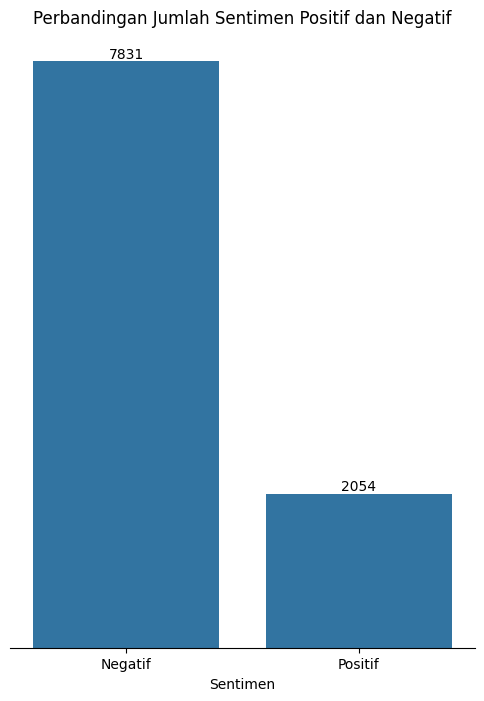

In [28]:
label_counts = df['label'].value_counts()

plt.figure(figsize=(6, 8))
ax = sns.barplot(x=label_counts.index, y=label_counts.values)
for i, value in enumerate(label_counts.values):
    ax.text(i, value + 0.5, str(value), ha='center', va='bottom')
sns.despine(left=True, right=True, top=True)
ax.set_ylabel('')
ax.set_yticks([])


ax.set_xlabel('Sentimen')
ax.set_title('Perbandingan Jumlah Sentimen Positif dan Negatif')
ax.set_xticks([0, 1])
ax.set_xticklabels(['Negatif', 'Positif'])

plt.show()


# Data Preprocessing

## Cleaning

Menghapus simbol, angka, url, serta lainnya untuk preprocessing teks

In [29]:
def clean_twitter_text(text):
  text = re.sub(r'@[A-Za-z0-9_]+', '', text)
  text = re.sub(r'#\w+', '', text)
  text = re.sub(r'https?://\S+', '', text)
  test = re.sub(r'RT[\s]+', '', text)
  text = re.sub(r'[^A-Za-z0-9 ]', '', text)
  text = re.sub(r'\s+', ' ', text)

  return text

In [30]:
df['Text'] = df['Text'].apply(clean_twitter_text)
df['Text'] = df['Text'].str.lower()
df

,Text,label
0,ganjar is getting more and more support now su...,Positive
1,ojoo lali yooo who is smart chooses pranowos r...,Positive
2,smart people support and reward pranowo well,Positive
3,we believe that pranowos reward is a gift from...,Positive
4,intelligent people support and reward pranowo ...,Positive
...,...,...
9995,rt ganjaristdltras ganjarist deltras east java...,Positive
9996,meaning reward pranowo the president,Positive
9997,more and more people are ready to support ganj...,Positive
9998,rt ganjaristdltras ganjarist deltras east java...,Positive


## Tokenisasi

RegexpTokenizer untuk mengambil kata-kata saja

In [31]:
regexp = RegexpTokenizer(r'\w+')
df['Text_token'] = df['Text'].apply(lambda x: regexp.tokenize(str(x)))
df.head()

,Text,label,Text_token
0,ganjar is getting more and more support now su...,Positive,"[ganjar, is, getting, more, and, more, support..."
1,ojoo lali yooo who is smart chooses pranowos r...,Positive,"[ojoo, lali, yooo, who, is, smart, chooses, pr..."
2,smart people support and reward pranowo well,Positive,"[smart, people, support, and, reward, pranowo,..."
3,we believe that pranowos reward is a gift from...,Positive,"[we, believe, that, pranowos, reward, is, a, g..."
4,intelligent people support and reward pranowo ...,Positive,"[intelligent, people, support, and, reward, pr..."


## Lematisasi

In [32]:
# Inisialisasi Lemmatizer
lemmatizer = WordNetLemmatizer()

In [33]:
# Mengubah tag POS dari format Penn Treebank ke format WordNet untuk lemmatisasi
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [34]:
# Melakukan lemmatisasi pada list token kata dengan mempertimbangkan POS tag
def lemmatize_tokens(tokens):
    tagged_tokens = pos_tag(tokens)
    lemmatized = [
        lemmatizer.lemmatize(word, get_wordnet_pos(pos))
        for word, pos in tagged_tokens
    ]
    return lemmatized

In [35]:
# Apply fungsi-fungsi lematisasi yang telah dibuat sebelumnya
df['Text_token'] = df['Text_token'].apply(lemmatize_tokens)

## Stopword

In [36]:
# Inisialisasi stop words atau kata-kata yang akan dihapus
stopwords = nltk.corpus.stopwords.words("english")
stopwords_gwehj = ['mr', 'will', 'come', 'make', 'know', 'want', 'really',
                   'must', 'great', 'time', 'still', 'top', 'two', 'one',
                   'goodness', 'hopefully', 'god', 'blessing', 'thank', 'pak',
                   'u', 'sir']
stopwords.extend(stopwords_gwehj)

In [37]:
# Menghapus kata yang ada pada list stopword
df.loc[:, 'Text_token'] = df.loc[:, 'Text_token'].apply(lambda x: [item for item in x if item not in stopwords])
df.head()

,Text,label,Text_token
0,ganjar is getting more and more support now su...,Positive,"[ganjar, get, support, support, city, batu, ma..."
1,ojoo lali yooo who is smart chooses pranowos r...,Positive,"[ojoo, lali, yooo, smart, chooses, pranowos, r..."
2,smart people support and reward pranowo well,Positive,"[smart, people, support, reward, pranowo, well]"
3,we believe that pranowos reward is a gift from...,Positive,"[believe, pranowos, reward, gift, allah, almig..."
4,intelligent people support and reward pranowo ...,Positive,"[intelligent, people, support, reward, pranowo..."


## Word Cloud

In [38]:
# Mengubah hasil proses teks kembali ke kalimat
df['Text_string'] = df['Text_token'].apply(lambda x: ' '.join([item for item in x]))
df.head()

,Text,label,Text_token,Text_string
0,ganjar is getting more and more support now su...,Positive,"[ganjar, get, support, support, city, batu, ma...",ganjar get support support city batu malang ea...
1,ojoo lali yooo who is smart chooses pranowos r...,Positive,"[ojoo, lali, yooo, smart, chooses, pranowos, r...",ojoo lali yooo smart chooses pranowos reward
2,smart people support and reward pranowo well,Positive,"[smart, people, support, reward, pranowo, well]",smart people support reward pranowo well
3,we believe that pranowos reward is a gift from...,Positive,"[believe, pranowos, reward, gift, allah, almig...",believe pranowos reward gift allah almighty in...
4,intelligent people support and reward pranowo ...,Positive,"[intelligent, people, support, reward, pranowo...",intelligent people support reward pranowo well


In [39]:
# Mengubah 'Text_string' ke tipe data string
df['Text_string'] = df['Text_string'].astype('str')
df['Text_string'] = df['Text_string'].astype(pd.StringDtype())
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9885 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Text         9885 non-null   object
 1   label        9885 non-null   object
 2   Text_token   9885 non-null   object
 3   Text_string  9885 non-null   string
dtypes: object(3), string(1)
memory usage: 386.1+ KB


Positive Sentiment

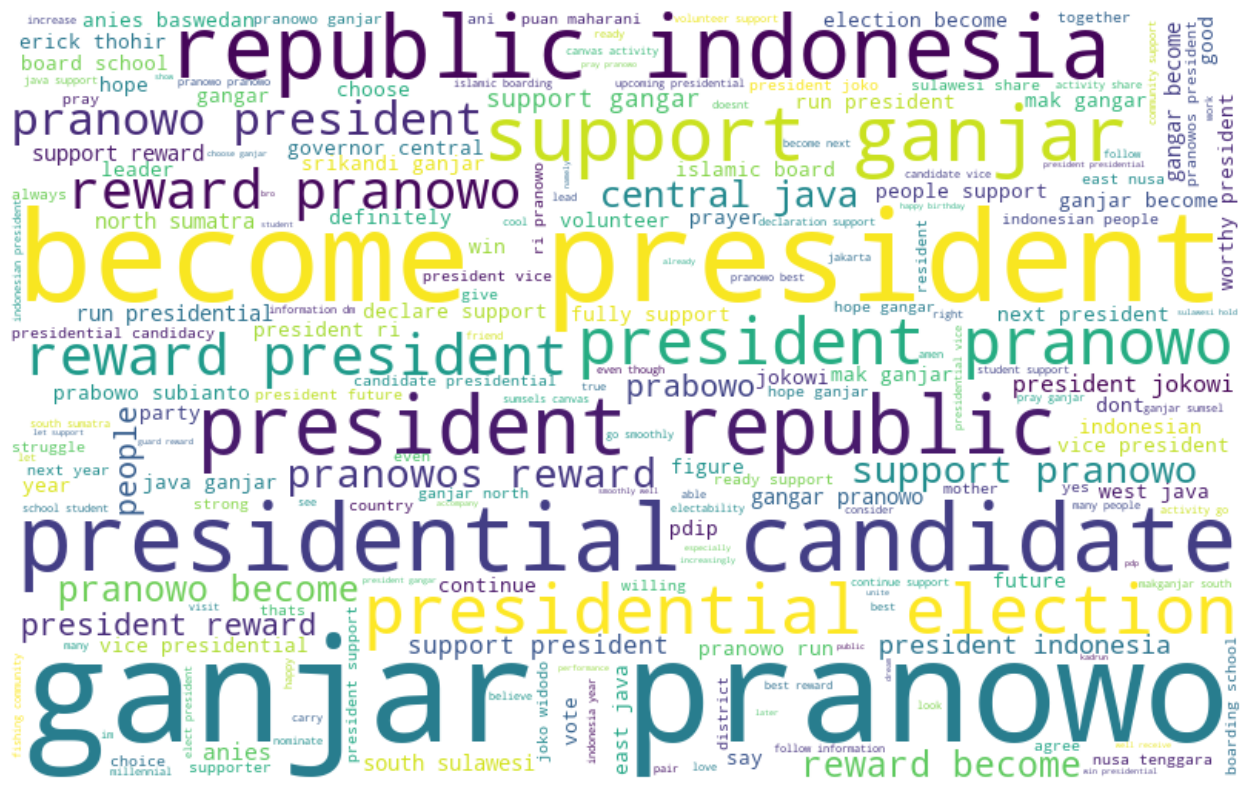

In [40]:
# Visualisasi wordcloud untuk sentimen berlabel positif
df_p = df[df['label'] == "Positive"]
all_words_lem = ' '.join([word for word in df_p['Text_string']])

from wordcloud import WordCloud
wordcloud = WordCloud(
    background_color='white',
    width = 800,
    height = 500,
    random_state = 21,
    max_font_size = 130
).generate(all_words_lem)
plt.figure(figsize = (20, 10))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off');

Negative Sentiment

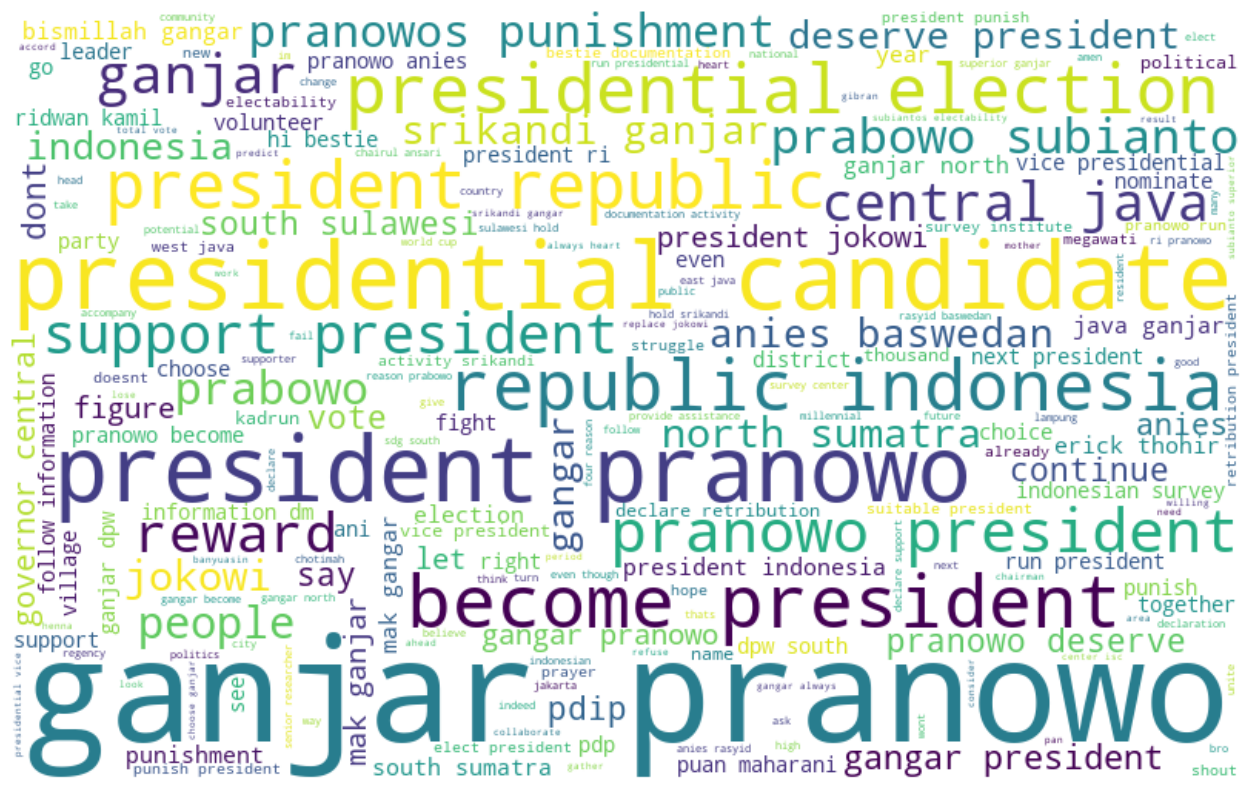

In [41]:
# Visualisasi wordcloud untuk sentimen berlabel negatif
df_p = df[df['label'] == "Negative"]
all_words_lem = ' '.join([word for word in df_p['Text_string']])

from wordcloud import WordCloud
wordcloud = WordCloud(
    background_color='white',
    width = 800,
    height = 500,
    random_state = 21,
    max_font_size = 130
).generate(all_words_lem)
plt.figure(figsize = (20, 10))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off');

## Modelling

In [42]:
# Mengubah label ke numerik
df['label'] = df['label'].apply(lambda x: 1 if x == 'Positive' else 0)
df.head()

,Text,label,Text_token,Text_string
0,ganjar is getting more and more support now su...,1,"[ganjar, get, support, support, city, batu, ma...",ganjar get support support city batu malang ea...
1,ojoo lali yooo who is smart chooses pranowos r...,1,"[ojoo, lali, yooo, smart, chooses, pranowos, r...",ojoo lali yooo smart chooses pranowos reward
2,smart people support and reward pranowo well,1,"[smart, people, support, reward, pranowo, well]",smart people support reward pranowo well
3,we believe that pranowos reward is a gift from...,1,"[believe, pranowos, reward, gift, allah, almig...",believe pranowos reward gift allah almighty in...
4,intelligent people support and reward pranowo ...,1,"[intelligent, people, support, reward, pranowo...",intelligent people support reward pranowo well


In [43]:
# Membagi data fitur dan target
X = df['Text_string']
y = df['label']

# Inisialisasi TF-IDF
tfid = TfidfVectorizer()

# Vektorisasi teks ke numerik
X_final =  tfid.fit_transform(X)

In [44]:
# Menerapkan SMOTE untuk menangani data tidak seimbang
smote = SMOTE()
X_res, y_res = smote.fit_resample(X_final, y)

# Split data ke train dan test
x_train, x_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

In [45]:
# Naive Bayes model
nb = MultinomialNB()
nb.fit(x_train,y_train)
nb_prediction =  nb.predict(x_test)

# SVM model
svm = LinearSVC()
svm.fit(x_train, y_train)
svm_prediction = svm.predict(x_test)

# Model Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(x_train, y_train)
lr_prediction = lr.predict(x_test)

## Evaluasi

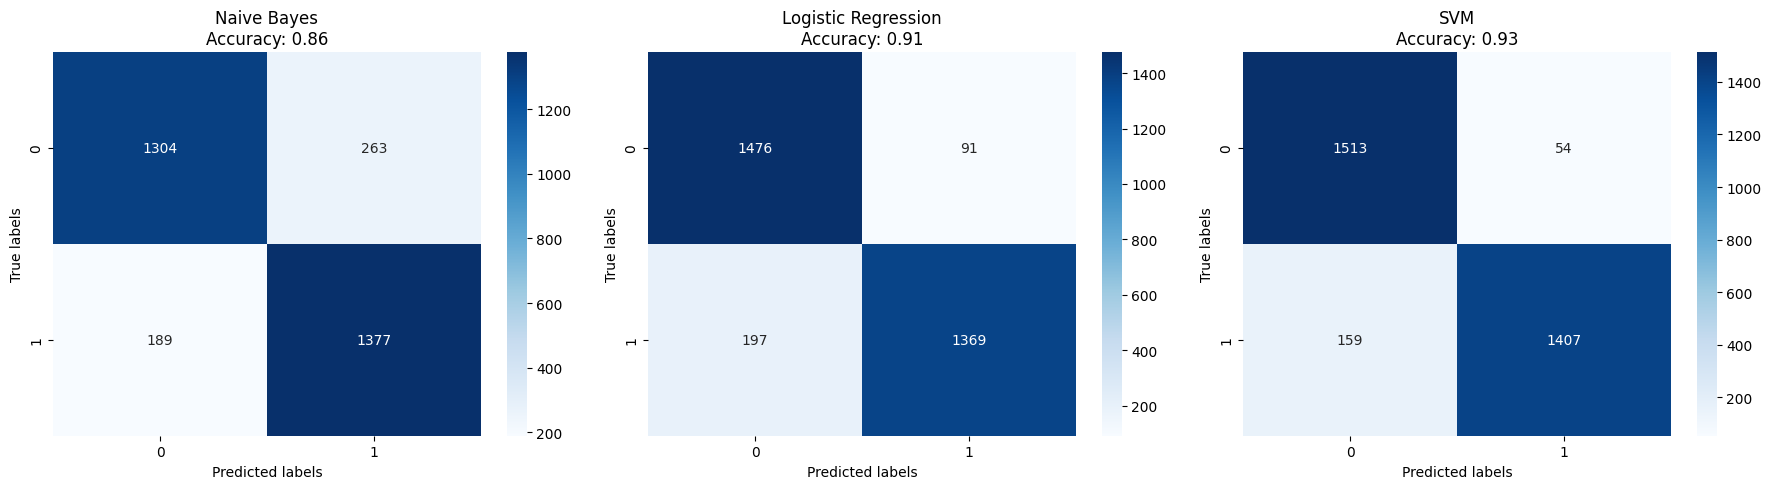

In [46]:
# Nilai akurasi masing-masing model
nb_accuracy = accuracy_score(y_test, nb_prediction)
lr_accuracy = accuracy_score(y_test, lr_prediction)
svm_accuracy = accuracy_score(y_test, svm_prediction)

# Plot untuk confusion matrix
plt.figure(figsize=(18, 5))

# Naive Bayes
plt.subplot(1, 3, 1)
conf_matrix = confusion_matrix(y_test, nb_prediction)
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title(f'Naive Bayes\nAccuracy: {nb_accuracy:.2f}')

# Logistic Regression
plt.subplot(1, 3, 2)
conf_matrix = confusion_matrix(y_test, lr_prediction)
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title(f'Logistic Regression\nAccuracy: {lr_accuracy:.2f}')

# SVM
plt.subplot(1, 3, 3)
conf_matrix = confusion_matrix(y_test, svm_prediction)
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title(f'SVM\nAccuracy: {svm_accuracy:.2f}')

plt.tight_layout()
plt.show()

C:\Users\alghi\AppData\Local\Temp\ipykernel_75000\372262375.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracies, palette='Blues')


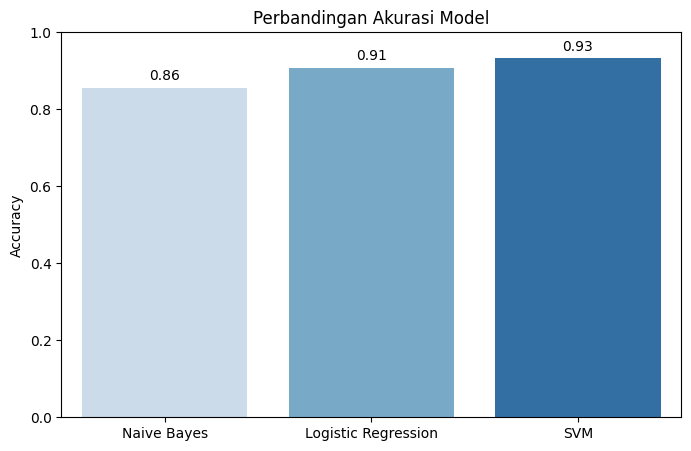

Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.83      0.85      1567
           1       0.84      0.88      0.86      1566

    accuracy                           0.86      3133
   macro avg       0.86      0.86      0.86      3133
weighted avg       0.86      0.86      0.86      3133


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      1567
           1       0.94      0.87      0.90      1566

    accuracy                           0.91      3133
   macro avg       0.91      0.91      0.91      3133
weighted avg       0.91      0.91      0.91      3133


SVM Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.97      0.93      1567
           1       0.96      0.90      0.93      1566

    accuracy                           0.93      3133
   macro avg       0.

In [47]:
# Perbandingan akurasi dalam bentuk grafik batang
plt.figure(figsize=(8, 5))
models = ['Naive Bayes', 'Logistic Regression', 'SVM']
accuracies = [nb_accuracy, lr_accuracy, svm_accuracy]
sns.barplot(x=models, y=accuracies, palette='Blues')
plt.title('Perbandingan Akurasi Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.02, f"{acc:.2f}", ha='center')
plt.show()

# Teks laporan klasifikasi untuk masing-masing model
print("Naive Bayes Classification Report:")
print(classification_report(y_test, nb_prediction))
print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, lr_prediction))
print("\nSVM Classification Report:")
print(classification_report(y_test, svm_prediction))


Top 10 Positive Words (Most Influential):
         Word    Weight
6133   reward  5.596362
7033  support  4.540431
5946    ready  3.743455
6531    share  3.637423
3177     hope  3.335750
6901   strong  3.230241
7898   worthy  3.176611
77    achieve  3.069557
3006    happy  2.900027
7842      win  2.814988

Top 10 Negative Words (Most Influential):
            Word    Weight
5808  punishment -4.197222
1971       doubt -2.674288
1251      christ -2.186527
1874    disaster -2.005681
7078       swing -1.934336
3005   happiness -1.923047
3974    komering -1.879206
3335     include -1.809127
4902    negative -1.736927
5004        note -1.675742


C:\Users\alghi\AppData\Local\Temp\ipykernel_75000\3883968944.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_positive, y='Word', x='Weight', palette='Blues_d')
C:\Users\alghi\AppData\Local\Temp\ipykernel_75000\3883968944.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_negative, y='Word', x='Weight', palette='Reds_d')


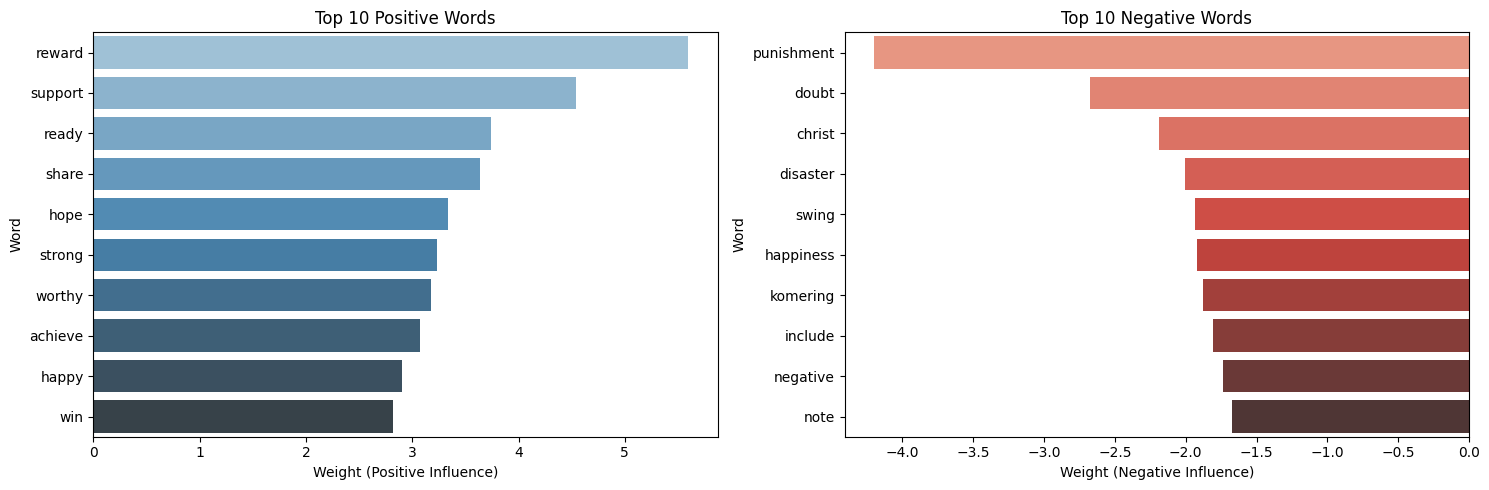

In [ ]:
# Nama fitur dari TF-IDF
feature_names = tfid.get_feature_names_out()

# Dapatkan koefisien dari model
if hasattr(svm, 'coef_'):
    coefficients = svm.coef_[0]
else:
    coefficients = svm.named_steps['classifier'].coef_[0]

# Buat DataFrame untuk bobot kata
weights_df = pd.DataFrame({
    'Word': feature_names,
    'Weight': coefficients
})

# Tampilkan 10 kata dengan bobot positif tertinggi
print("\nTop 10 Positive Words (Most Influential):")
top_positive = weights_df.sort_values('Weight', ascending=False).head(10)
print(top_positive)

# Tampilkan 10 kata dengan bobot negatif tertinggi
print("\nTop 10 Negative Words (Most Influential):")
top_negative = weights_df.sort_values('Weight', ascending=True).head(10)
print(top_negative)

# Visualisasi
plt.figure(figsize=(15, 5))

# Plot untuk kata positif
plt.subplot(1, 2, 1)
sns.barplot(data=top_positive, y='Word', x='Weight', palette='Blues_d')
plt.title('Top 10 Positive Words')
plt.xlabel('Weight (Positive Influence)')

# Plot untuk kata negatif
plt.subplot(1, 2, 2)
sns.barplot(data=top_negative, y='Word', x='Weight', palette='Reds_d')
plt.title('Top 10 Negative Words')
plt.xlabel('Weight (Negative Influence)')

plt.tight_layout()
plt.show()